# Step 6: Add data and model monitoring
After executing five previous notebooks, you have a production-ready solution with automated model building and model deployment CI/CD pipelines.

In this notebook you are going to use [Amazon SageMaker model monitor](https://aws.amazon.com/sagemaker/model-monitor/) to add continuous and automated [monitoring of the data quality](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-quality.html) for the traffic to your real-time SageMaker inference endpoints. You also implement [model monitoring](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality.html) to detect performance drift and model metric anomalies.

Using Model Monitor integration with [Amazon EventBridge](https://aws.amazon.com/eventbridge/) you can implement automated response and remediation to any detected issues with data and model quality. For example, you can launch an automated model retraining if the model performance falls below a specific threshold.

Additionally to data and model quality monitoring you can implement [bias drift](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-model-monitor-bias-drift.html) and [feature attribution drift](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-model-monitor-feature-attribution-drift.html) monitoring.

![](img/six-steps-6.png)

<div class="alert alert-info"> 💡
The minimal prerequisite for this notebook is to complete the setup (00-start-here.ipynb) and step 3 (03-sagemaker-pipeline.ipynb) notebooks.
</div>

<div class="alert alert-info"> 💡
This notebook contains two parts:<br/>
- Part 1: Monitor data quality<br/>
- Part 2: Monitor model quality<br/>
<br/>

You need approximately between 60 and 90 minutes to go through this notebook. To optimize time you can execute both parts independently. For both parts you must execute all following sections up to the <strong>Part 1</storng>.
</div>

<div class="alert alert-info"> Make sure you using <code>Data Science 3.0</code> image in Studio for this notebook.</div>

In [ ]:
%pip install jsonlines tqdm

In [ ]:
import boto3
import botocore
import sagemaker 
import json
import jsonlines
import random
from tqdm import trange
from sagemaker.predictor import Predictor
from sagemaker import ModelPackage
import time
from time import gmtime, strftime
from datetime import datetime, timedelta
import uuid
import pandas as pd
import numpy as np
from sagemaker.model_monitor import (
    DefaultModelMonitor,
    DataCaptureConfig,
    CronExpressionGenerator,
    ModelQualityMonitor,
    EndpointInput,
)
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.model_monitor import DataCaptureConfig
from utils.monitoring_utils import run_model_monitor_job
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.clarify import (
    BiasConfig,
    DataConfig,
    ModelConfig,
    ModelPredictedLabelConfig,
    SHAPConfig,
)
from urllib.parse import urlparse

sagemaker.__version__

In [ ]:
sm = boto3.client("sagemaker")
s3 = boto3.client("s3")

In [ ]:
session = sagemaker.Session()

In [ ]:
pd.set_option("display.max_colwidth", None)

In [ ]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

## How Model Monitor works
Amazon SageMaker Model Monitor automatically monitors ML models in production and notifies you when quality issues arise. Model Monitor uses rules to detect drift in your models and data and alerts you when it happens. The following figure shows how this process works.

![](img/data-monitoring-architecture.png)

The process for setting up and using the data monitoring:
1. Enable the SageMaker endpoint to capture data from incoming requests to a trained ML model and the resulting model predictions
2. Create a baseline from the dataset that was used to train the model. The baseline computes metrics and suggests constraints for the metrics. 
3. Create a monitoring schedule specifying what data to collect, how often to collect it, and how to analyze it. Data traffic to your model and predictions from the model are compared to the constraints, and are reported as violations if they are outside the constrained values. You can define multiple monitoring schedule per endpoint
4. Inspect the reports, which compare the latest data with the baseline, and watch for any violations reported and for metrics and notifications from Amazon CloudWatch
5. Implement observability for your ML models with Amazon CloudWatch and event-based architecture with Amazon EventBridge. You can automate data and model updates, model retraining, and user notification based on the data and model quality events

## Real-time inference data capture from a SageMaker endpoint
To work with the model monitor in this notebook, you need a real-time inference endpoint and data capture configured on that endpoint. 
If you completed the [step 5](05-deploy.ipynb) notebook, there is at least one deployed endpoint with the name like `model-deploy-19-20-31-59-staging`. If you don't have an active endpoint, you need to create one.

In [ ]:
# List all deployed real-time endpoints. Depending on your existing environment you might have multiple endpoints
endpoints = sm.list_endpoints(StatusEquals="InService")["Endpoints"]
endpoint_name = ""

if not len(endpoints):
    print(f"There is no deployed active endpoints. You must have at least one endpoint. Run the step 3 pipeline to create a model")
else:
    endpoint_name = endpoints[0]['EndpointName']
    print(f"There are {len(endpoints)} active inference endpoints. Checking the data capture configuration:")
    
for ep in endpoints:
    print(f"Data capture configuration for {ep['EndpointName']}:")
    dcc = sm.describe_endpoint(EndpointName=ep['EndpointName']).get('DataCaptureConfig')
    print(f"{json.dumps(dcc, indent=2)}" if dcc else f"<No data capture config for this endpoint>")

<div class="alert alert-info"> 💡
If there is no active endpoints, you can run the step 3 notebook to create a model and register the model in the model registry.
If you have an active endpoint, you can go to the <strong>Check the data capture configuration</strong> section.
</div>

### Deploy a model from the model registry as a real-time endpoint
Run this section only if you'd like to create an endpoint with a model from the model registry you created in the step 3 pipeline. If you already have an active endpoint you'd like to use for model monitoring, skip this section and go to the section **Check the data capture configuration**.

The following code checks if there is a model package group created by the step 3 pipeline and if there are any registered model versions in the package.

In [ ]:
try:
    model_package_group = sm.describe_model_package_group(ModelPackageGroupName=model_package_group_name)
    print(f"There is model package group {model_package_group_name} in the model registry")
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print("******* ERROR *********")
        print(f"Model package group with the name {model_package_group_name} is not found. You need to run the step 3 pipeline to create a model")

In [ ]:
model_packages = []

# Find the latest model package
# Set the parameter ModelApprovalStatus='Approved' if you'd like to get only the approved packages
# Sort by the CreationTime
for p in sm.get_paginator('list_model_packages').paginate(
    ModelPackageGroupName=model_package_group_name,
    # ModelApprovalStatus='Approved',
    SortBy="CreationTime",
    SortOrder="Descending",
    ):
    model_packages.extend(p["ModelPackageSummaryList"])
    
if not len(model_packages):
    print("There is no model packages in the model package group {model_package_group_name}. You need to run the step 3 pipeline to create a model")
    
latest_model_package_arn = model_packages[0]['ModelPackageArn']
print(f"The most recent model package is version {model_packages[0]['ModelPackageVersion']}, {latest_model_package_arn}")


You can only deploy a model with the model approval status `Approved`, so the next code cell updates the status.

In [ ]:
r = sm.describe_model_package(ModelPackageName=latest_model_package_arn)

if r['ModelApprovalStatus'] not in ['Approved']:
    sm.update_model_package(
        ModelPackageArn=latest_model_package_arn,
        ModelApprovalStatus="Approved",
    )
else:
    print(f"Model approval status is {r['ModelApprovalStatus']} for the model package {latest_model_package_arn}")

In [ ]:
# Create a model from the registry using Python SDK
model = ModelPackage(role=sm_role, 
                     model_package_arn=model_packages[0]['ModelPackageArn'], 
                     sagemaker_session=session)

In [ ]:
endpoint_name = f"from-idea-to-prod-endpoint-{strftime('%d-%H-%M-%S', gmtime())}"

data_capture_config = DataCaptureConfig(
            enable_capture=True,
            sampling_percentage=100,
            destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
            csv_content_types=["text/csv"],
        )

In [ ]:
# Deploy the model
model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    wait=False,
    data_capture_config=data_capture_config,
    endpoint_name=endpoint_name,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

In [ ]:
# Wait until the endpoint has the status InService, it takes approximately 5 min
waiter = session.sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

### Check the data capture configuration
If you completed the step 5 [notebook](05-deploy.ipynb), the model deployment CI/CD pipeline contains an infrastructure as code (IaS) data capture configuration for the deployed endpoints. If you clone the project's code repository to the Studio file system, you can browse the project files. Let's take a look into the endpoint configuration.

The CloudFormation deployment template `endpoint-config-template.yml` in the project directory enables data capture for the endpoint configuration:
```yaml
EndpointConfig:
    Type: AWS::SageMaker::EndpointConfig
    Properties:
      ProductionVariants:
        - InitialInstanceCount: !Ref EndpointInstanceCount
          InitialVariantWeight: 1.0
          InstanceType: !Ref EndpointInstanceType
          ModelName: !GetAtt Model.ModelName
          VariantName: AllTraffic
      DataCaptureConfig:
          EnableCapture: !Ref EnableDataCapture 
          InitialSamplingPercentage: !Ref SamplingPercentage
          DestinationS3Uri: !Ref DataCaptureUploadPath
          CaptureOptions:
            - CaptureMode: Input
            - CaptureMode: Output
          CaptureContentTypeHeader:
            CsvContentTypes:
              - "text/csv"
```

The MLOps deploy project you created in the step 4 parametrizes all settings in the CloudFormation template.
The configuration files `prod-config.json` and `staging-config.json` provide the actual values for `EnableCapture`, `InitialSamplingPercentage`, and `DestinationS3Uri`:
```json
{
  "Parameters": {
    "StageName": "prod",
    "EndpointInstanceCount": "1",
    "EndpointInstanceType": "ml.m5.large",
    "SamplingPercentage": "80",
    "EnableDataCapture": "true"
  }
}
```

If you haven't executed step 4 notebook and deployed an endpoint with the model version from the model registry, let's check the endpoint configuration and see how data capture is confgured.

<div class="alert alert-info"> 💡
The endpoint_name variable must be set by now by the previous code cells. If it's not set, highly probably you don't have any active endpoint. Make sure you completed the section <strong>Deploy a model from the model registry as a real-time endpoint</strong>. 
</div>

In [ ]:
# Get the data capture configuration for the endpoint
# endpoint_name = "model-deploy-16-21-26-26-staging" # must be set before, but you can use any suitable endpoint

if not endpoint_name:
    print(f"You must have at least on endpoint with data capture configuration enabled!")
else:
    print(f"Checking the data capture configuration for the endpoint {endpoint_name}")
    data_capture_config = sm.describe_endpoint(EndpointName=endpoint_name)['DataCaptureConfig']
    data_capture_s3_url = data_capture_config['DestinationS3Uri']
    data_capture_bucket = data_capture_s3_url.split('/')[2]
    data_capture_prefix = '/'.join(data_capture_s3_url.split('/')[3:])

    print(json.dumps(data_capture_config, indent=2))
    print(f"Data capture S3 url: {data_capture_s3_url}")
    
    if not data_capture_config['EnableCapture']:
        print(f"Data capture config for the endpoint {endpoint_name} IS NOT ENABLED. You need to enable data capture for monitoring")

### Define helper functions
Define some helper functions with code snippets that you're going to use throughout this notebook.

In [ ]:
# Send data to the endpoint
def generate_endpoint_traffic(predictor, data):
    l = len(data)
    for i in trange(l):
        predictions = np.array(predictor.predict(data.iloc[i].values), dtype=float).squeeze()

In [ ]:
# Get all file keys under a specified prefix
def get_file_list(bucket, prefix):
    try:
        files = [f.get("Key") for f in s3.list_objects(Bucket=bucket, Prefix=prefix).get("Contents")]
        print(f"Found {len(files)} files in s3://{bucket}/{prefix}")
        
        return files
    except TypeError:
        print(f"No files found in s3://{bucket}/{prefix}")
        return []

In [ ]:
# Get S3 url for the latest captured data
def get_latest_data_capture_s3_url(bucket, prefix):
    capture_files = get_file_list(bucket, prefix)
    
    if capture_files:
        latest_data_capture_s3_url = f"s3://{bucket}/{'/'.join(capture_files[-1].split('/')[:-1])}"

        print(f"Latest data capture S3 url: {latest_data_capture_s3_url}")
        
        return latest_data_capture_s3_url
    else:
        return None

In [ ]:
# Get S3 url for the latest monitoring job output
def get_latest_monitoring_report_s3_url(job_name):
    monitor_job = sm.list_processing_jobs(
        NameContains=job_name,
        SortOrder='Descending',
        MaxResults=2
    )['ProcessingJobSummaries'][0]['ProcessingJobName']

    monitoring_job_output_s3_url = sm.describe_processing_job(
        ProcessingJobName=monitor_job
    )['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']

    print(f"Latest monitoring report S3 url: {monitoring_job_output_s3_url}")
    
    return monitoring_job_output_s3_url

In [ ]:
# Helper to load a json file from S3
def load_json_from_file(file_s3_url):
    bucket = file_s3_url.split('/')[2]
    key = '/'.join(file_s3_url.split('/')[3:])
    print(f"Load JSON from: {bucket}/{key}")
    
    return json.loads(
        s3.get_object(Bucket=bucket, 
                      Key=key)["Body"].read().decode("utf-8")
    )

In [ ]:
def get_latest_monitor_execution(monitor):
    mon_executions = monitor.list_executions()

    if len(mon_executions):
        latest_execution = mon_executions[-1]  # get the latest execution
        latest_execution.wait(logs=False)

        print(f"Latest execution status: {latest_execution.describe().get('ProcessingJobStatus')}")
        print(f"Latest execution result: {latest_execution.describe().get('ExitMessage')}")

        latest_job = latest_execution.describe()
        if latest_job["ProcessingJobStatus"] != "Completed":
            print("No completed executions to inspect further")
        else:
            report_uri = latest_execution.output.destination
            print(f"Report Uri: {report_uri}")
        
        return latest_execution
    else:
        print("No monitoring schedule executions found")
        return None

### Generate endpoint traffic and captured data
You must send some data to an endpoint for inference to generate data capture.
If you need to add or update the data capture configuration for the endpoint, you can use `DataCaptureConfig` and call [`update_data_capture_config()`](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor.update_data_capture_config) method of the predictor.

In [ ]:
# Create a predictor class for the endpoint
predictor = Predictor(
    endpoint_name=endpoint_name, 
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer()
)

In [ ]:
# If data capture is not enabled, enable it. 
# Note, that the call to update_data_capture_config updates the endpoint and it can take up to 10 min
if not data_capture_config['EnableCapture']:
    # Update data capture config for settings we use in this notebook
    data_capture_config = DataCaptureConfig(
        enable_capture=True,
        sampling_percentage=100,
        destination_s3_uri=data_capture_s3_url,
        csv_content_types=["text/csv"],
    )

    predictor.update_data_capture_config(data_capture_config)

Use test dataset prepared in the [step 2](02-sagemaker-containers.ipynb) or produced by the pipeline in the [step 3](02-sagemaker-pipeline.ipynb) notebooks and saved on the EFS volume:

In [ ]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

In [ ]:
# Set the number of data vectors from the test dataset sent to the inference endpoint
number_of_vectors = 100

In [ ]:
test_x = pd.read_csv("tmp/test_x.csv", names=[f'_c{i}' for i in range(59)]).sample(number_of_vectors)

In [ ]:
test_x.head(1)

Send the data to the endpoint:

In [ ]:
generate_endpoint_traffic(predictor, test_x)

### View captured data
Now list the data capture files stored in Amazon S3. The data is stored as `jsonl` an Amazon S3 path format is `s3://{data-capture-destination-s3-url}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`.

Wait until captured data appears in the Amazon S3 bucket, it may take several minutes.

In [ ]:
# If you run this notebook not the first time, there might be some data capture files from the previous runs
# We recommend to delete all existing files under the data capture S3 path to avoid any inconsistences
# Uncomment and run the following line to delete all files under the data capture S3 path

# !aws s3 rm {data_capture_s3_url} --recursive

In [ ]:
# You might need to execute this line several times until you see the captured data
!aws s3 ls {data_capture_s3_url} --recursive

In [ ]:
capture_files = get_file_list(data_capture_bucket, data_capture_prefix)

In [ ]:
assert len(capture_files) > 0, "Wait until the capture data delivered to the Amazon S3 bucket"

In [ ]:
capture_files[0]

Each inference request is captured in one line in the `jsonl` file. The line contains both the input and output merged together. In the example, you provided the ContentType as `text/csv` which is reflected in the `observedContentType` value. Also, you expose the encoding that you used to encode the input and output payloads in the capture format with the encoding value.

In [ ]:
# Download a capture data file and print it's content
file_key = capture_files[-1]
S3Downloader.download(f"s3://{data_capture_bucket}/{file_key}", f"./tmp")

print(f"Content of the capture file:")
# Read the jsonl file and show the first object
with jsonlines.open(f"./tmp/{file_key.split('/')[-1]}") as reader:      
    print(json.dumps(reader.read(), indent=2))
    # print(json.dumps(reader.read(), indent=2))

## Part 1: Monitor data quality
In this part you learn how to setup data quality monitoring for SageMaker real-time endpoints.

To enable inference data quality monitoring and evaluation you must:
1. Enable [data capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html)
1. [Create a baseline](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-create-baseline.html) with which you compare the realtime traffic
1. Once a baseline is ready, [schedule monitoring jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-scheduling.html) to continously evaluate and compare against the baseline
1. [See and interpret the results](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-results.html) of monitoring jobs
1. [Integrate data quality monitoring](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-cloudwatch.html) with Amazon CloudWatch

### Create a baselining job with the training dataset
The whole dataset with which you trained and tested the model is usually a good baseline dataset. Note that the baseline dataset data schema and the inference dataset schema should exactly match (i.e. the number and order of the features).

From the baseline dataset you can ask Amazon SageMaker to suggest a set of baseline _constraints_ and generate descriptive _statistics_ to explore the data. Model Monitor provides a [built-in container](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-built-container.html) that provides the ability to suggest the constraints automatically for CSV and flat JSON input. This `sagemaker-model-monitor-analyzer` container also provides you with a range of model monitoring capabilities, including constraint validation against a baseline, and emitting Amazon CloudWatch metrics. This container is based on Spark and is built with [Deequ](https://github.com/awslabs/deequ). 

<div class="alert alert-info"> 💡 <strong> All column names in your baseline dataset must be compliant with Spark. For column names, use only lowercase characters, and _ as the only special character. </strong>
</div>

Use the baseline dataset you created in the [step 2](02-sagemaker-containers.ipynb) notebook data processing. The baseline dataset is the full dataset without header, index, and label column.

In [ ]:
!aws s3 ls {baseline_s3_url}/

In [ ]:
baseline_results_s3_url = f"{baseline_s3_url}/results"
data_mon_reports_s3_url = f"{baseline_s3_url}/reports"
baseline_dataset_uri = f"{baseline_s3_url}/baseline.csv"

Use the Python SDK class [`DefaultModelMonitor`](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.DefaultModelMonitor) to create a data monitor and interact with it:

In [ ]:
data_monitor = DefaultModelMonitor(
    role=sm_role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=session,
)

Start a SageMaker processing job on the baseline data to profile data and suggest constraints.

In [ ]:
data_baseline_job_name = f"from-idea-to-prod-data-baselining-{strftime('%d-%H-%M-%S', gmtime())}-{str(uuid.uuid4())[:8]}"

data_baseline_job = data_monitor.suggest_baseline(
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=False),
    output_s3_uri=baseline_results_s3_url,
    wait=False,
    logs=False,
    job_name=data_baseline_job_name,
)

print(data_baseline_job_name)

The baselining job takes about 7 minutes to complete:



In [ ]:
data_baseline_job.wait(logs=False)

### See the generated statistics and constraints
After the baselining jobs finished, it saves the baseline statistics to the `statistics.json` file and the suggested baseline constraints to the `constraints.json` file in the location you specify with `output_s3_uri`.

In [ ]:
data_monitor.describe_latest_baselining_job()

In [ ]:
!aws s3 ls {baseline_results_s3_url}/

In [ ]:
data_statistics_s3_url = f"{baseline_results_s3_url}/statistics.json"
data_constraints_s3_url = f"{baseline_results_s3_url}/constraints.json"

Copy statistics and constraints JSON files to the Studio EFS:

In [ ]:
!aws s3 cp {data_constraints_s3_url} ./tmp/
!aws s3 cp {data_statistics_s3_url} ./tmp/

In [ ]:
!head -20 tmp/constraints.json

In [ ]:
!head -20 tmp/statistics.json

Load the generated JSON as Pandas DataFrame and see the content of `statistics.json` and `constaints.json`:

In [ ]:
baseline_job = data_monitor.latest_baselining_job
statistics_df = pd.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
statistics_df.head()

In [ ]:
constraints_df = pd.json_normalize(
    baseline_job.suggested_constraints().body_dict["features"]
)
constraints_df.head()

For this dataset the baselining job suggest three constraints:
1. DataType
2. Completeness
3. Is non-negative

Additionally, the Model Monitor prebuilt container does missing and extra column check, baseline drift check, and categorical values check. Refer to [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-violations.html) for more details.

In a real-world project you can add your own constraints the data must comply with.

Next you schedule and run a monitoring job to validate incoming data against these constraints and statistics.

### Create a data monitoring schedule
With a monitoring schedule, SageMaker launches processing jobs at a specified frequency to analyze the data collected during a given period. SageMaker provides a [built-in container](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-built-container.html) for performing analysis on tabular datasets. In the processing job, SageMaker compares the dataset for the current analysis with the baseline statistics and constraints and generates a violations report. In addition, CloudWatch metrics are emitted for each data feature under analysis.

#### Implement custom record processing with a preprocessing script
You can extend Model Monitor by providing a custom record preprocessing function. In this function you can implement your own filtering or preprocessing of every data record. For example, you can skip some records from analysis based on values or some event metadata. Refer to [Preprocessing and Postprocessing](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-and-post-processing.html) documentation for more details and examples.

When you created a monitoring baseline, you used the baseline dataset with all features but without the target column. The Model Monitor by default concatenates model input and output, resulting in a dataset which contains all features plus the label. If you don't preprocess records before passing them to Model Monitor, the number of columns in the baseline dataset won't match the number of columns in the data capture record, and Model Monitor will report a `extra_column_check` violation. To avoid this situation, you need either to include the target column in the baselining or remove model output from the monitored records. This notebook uses the latter approach and provides a preprocessing script that returns only input data without the target column.

For another example of custom preprocessing see the blog post [Design a compelling record filtering method with Amazon SageMaker Model Monitor](https://aws.amazon.com/blogs/machine-learning/design-a-compelling-record-filtering-method-with-amazon-sagemaker-model-monitor/).

In [ ]:
# uncomment to see the file
# !pygmentize ./record_preprocessor.py

In [ ]:
# Upload the preprocessing script to S3
record_preprocessor_s3_url = f"s3://{bucket_name}/{bucket_prefix}/code"

In [ ]:
!aws s3 cp ./record_preprocessor.py {record_preprocessor_s3_url}/

In [ ]:
data_mon_schedule_name = "from-idea-to-prod-data-monitor-schedule-" + strftime(
    "%Y-%m-%d-%H-%M-%S", gmtime()
)

data_monitor.create_monitoring_schedule(
    monitor_schedule_name=data_mon_schedule_name,
    endpoint_input=predictor.endpoint_name,
    record_preprocessor_script=f"{record_preprocessor_s3_url}/record_preprocessor.py",
    # post_analytics_processor_script=s3_code_postprocessor_uri,
    output_s3_uri=data_mon_reports_s3_url,
    statistics=data_monitor.baseline_statistics(),
    constraints=data_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

In [ ]:
while data_monitor.describe_schedule()["MonitoringScheduleStatus"] != "Scheduled":
    print(f"Waiting until data monitoring schedule status becomes Scheduled")
    time.sleep(3)

data_monitor.describe_schedule()

### Generate compliant traffic
Generate traffic that won't trigger any violations. Use the `test_x.csv` dataset to send requests to the endpoint.

In [ ]:
generate_endpoint_traffic(predictor, test_x)

### See the captured data
List captured data files under `data_capture_s3_url`. Wait couple of minutes before the captured data appears in the Amazon S3 bucket.

In [ ]:
# If you run this notebook not the first time, there might be some data capture files from the previous runs
# We recommend to delete all previous captured files under the data capture S3 path to avoid any inconsistences
# Uncomment and run the following line to delete all files under the data capture S3 path

# !aws s3 rm {data_capture_s3_url} --recursive

In [ ]:
!aws s3 ls {data_capture_s3_url} --recursive

### Launch a manual monitoring job
You can launch a monitoring job manually and don't wait until a configured data monitor schedule execution. You created an hourly schedule, so you need to wait until you cross the hour boundary to see some schedule executions.

Since the Model Monitor uses a [built-in container](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-built-container.html) and a SageMaker [processing job](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) to run analysis of the captured data, you can manually configure and run a monitoring job. 

This [repository](https://github.com/aws-samples/reinvent2019-aim362-sagemaker-debugger-model-monitor/tree/master/02_deploy_and_monitor) contains an implementation of a helper function to manually run a monitoring job.

In [ ]:
# uncomment to see the code
# !pygmentize ./utils/monitoring_utils.py

Get an S3 url for the latest captured data files:

In [ ]:
latest_data_capture_s3_url = get_latest_data_capture_s3_url(data_capture_bucket, data_capture_prefix)

In [ ]:
print(f"Data capture path: {latest_data_capture_s3_url}")
print(f"Data baseline statistics file: {data_statistics_s3_url}")
print(f"Data baseline constraints file: {data_constraints_s3_url}")
print(f"Data monitor report output path: {data_mon_reports_s3_url}")
print(f"Record preprocessor script path: {record_preprocessor_s3_url}")

Run a monitoring job, it takes about 7 minutes:



In [ ]:
from utils.monitoring_utils import run_model_monitor_job

run_model_monitor_job(
    region=region,
    instance_type="ml.m5.xlarge",
    role=sm_role,
    data_capture_path=latest_data_capture_s3_url,
    statistics_path=data_statistics_s3_url,
    constraints_path=data_constraints_s3_url,
    reports_path=data_mon_reports_s3_url,
    instance_count=1,
    preprocessor_path=f"{record_preprocessor_s3_url}/record_preprocessor.py",
    postprocessor_path=None,
    publish_cloudwatch_metrics="Disabled",
    logs=False,
)

### See the monitoring job output
Let's check what reports the monitoring job generated. 

In [ ]:
manual_monitoring_job_output_s3_url = get_latest_monitoring_report_s3_url("sagemaker-model-monitor-analyzer")

In [ ]:
!aws s3 ls {manual_monitoring_job_output_s3_url}/

Load the monitoring report and see if there are any violations:

In [ ]:
violations = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraint_violations.json")

As you sent only compliant data to the endpoint, there must be no violations for the captured data.

In [ ]:
pd.json_normalize(violations["violations"])

You can also copy the constraint violations report to the Studio EFS and print the content of the file:

In [ ]:
!aws s3 cp {manual_monitoring_job_output_s3_url}/constraint_violations.json ./tmp/

In [ ]:
!head ./tmp/constraint_violations.json

Now load the newly calculated statistics and constratins based on the captured dataset.

In [ ]:
statistics = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/statistics.json")
constraints = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraints.json")

print(f"Records processed: {statistics['dataset']['item_count']}")

In [ ]:
pd.json_normalize(statistics["features"]).head()

In [ ]:
pd.json_normalize(constraints["features"]).head()

### What is monitored
Refer to [Schema for Violations](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-violations.html) in the Developer Guide to see what constraints are monitored by the model monitor. You can configure a tolerance threshold that fits your specific data quality requirements.  To configure the thresholds, you must change the `monitoring_config` section of the baseline `constraints.json` file:

In [ ]:
with open("tmp/constraints.json", "r") as c:
    data = c.read()
    
print(json.dumps(json.loads(data)["monitoring_config"], indent=2))

To modify monitoring configuration, change this section and upload the file to Amazon S3.
You can use `Robust` or `Simple` method to detect a data distribution drift, refer to [Schema for Constraints](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-constraints.html) in the Developer Guide. `Robust` method is recommended for small datasets and based on the [Two-sample Kolmogorov-Smirnov test](https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

### Generate non-compliant traffic
Now generate traffic that will trigger the violation in the model monitor data quality check.

In [ ]:
non_compliant_pd = test_x.copy()
non_compliant_pd.iloc[:,0] = -99.99

In [174]:
non_compliant_pd.head()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c49,_c50,_c51,_c52,_c53,_c54,_c55,_c56,_c57,_c58
823,-99.99,5,999,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3849,-99.99,2,999,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
759,-99.99,1,999,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1471,-99.99,3,999,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3661,-99.99,1,999,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Remove previous saved data capture from the S3 bucket
latest_data_capture_s3_url = get_latest_data_capture_s3_url(data_capture_bucket, data_capture_prefix)

In [ ]:
# If you run this notebook not the first time, there might be some data capture files from the previous runs
# We recommend to delete all existing files under the data capture S3 path to avoid any inconsistences
# Uncomment and run the following line to delete all files under the data capture S3 path

# !aws s3 rm {latest_data_capture_s3_url} --recursive

In [ ]:
generate_endpoint_traffic(predictor, non_compliant_pd)

### See the captured data
List captured data files under `data_capture_s3_url`. Wait couple of minutes before the captured data appears in the Amazon S3 bucket.

In [ ]:
!aws s3 ls {data_capture_s3_url} --recursive

### Launch a manual monitoring job
Let's run a manual monitoring job again to analyze the capture data:

In [ ]:
latest_data_capture_s3_url = get_latest_data_capture_s3_url(data_capture_bucket, data_capture_prefix)

In [ ]:
run_model_monitor_job(
    region=region,
    instance_type="ml.m5.xlarge",
    role=sm_role,
    data_capture_path=latest_data_capture_s3_url,
    statistics_path=data_statistics_s3_url,
    constraints_path=data_constraints_s3_url,
    reports_path=data_mon_reports_s3_url,
    instance_count=1,
    preprocessor_path=f"{record_preprocessor_s3_url}/record_preprocessor.py",
    postprocessor_path=None,
    publish_cloudwatch_metrics="Disabled",
    logs=False,
)

### See the monitoring job output
Let's check what reports the monitoring job generated. Since you send non-compliant data to the endpoint, you must see a violation report.

In [ ]:
manual_monitoring_job_output_s3_url = get_latest_monitoring_report_s3_url("sagemaker-model-monitor-analyzer")

In [ ]:
!aws s3 ls {manual_monitoring_job_output_s3_url}/

Load the monitoring report and see the violations:

In [ ]:
violations = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraint_violations.json")
violations

In [ ]:
pd.json_normalize(violations["violations"])

In [ ]:
statistics = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/statistics.json")
constraints = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraints.json")

print(f"Records processed: {statistics['dataset']['item_count']}")

In [ ]:
pd.json_normalize(statistics["features"]).head()

In [ ]:
pd.json_normalize(constraints["features"]).head()

### List schedule executions and monitoring reports
<div class="alert alert-info"> 
In this section you explore the scheduled executions of the monitoring job and their results. To have any executions and reports you have to wait until the top of the hour for an execution to complete. If you don't have any executions of the monitor scheduled, check if you send any traffic to the endpoint and if your monitor schedule is properly configured.
</div>

You created a hourly schedule above that begins executions on the hour plus 0-20 min buffer. You will have to wait till the clock hit the hour. You can also change the schedule.

<div class="alert alert-info"> 
While waiting for the scheduled execution of the monitoring job, you can continue with the <strong>Part 2: Monitor model quality</strong> and come back to this section to check the monitor job executions.
</div>

This section demonstrates how to work with scheduled monitoring job execution. The Python SDK class [`DefaultModelMonitor`](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.DefaultModelMonitor) implements helper methods to load and see the executions and monitoring reports.

List executions and view a monitoring job details:

In [ ]:
latest_execution = get_latest_monitor_execution(data_monitor)

See details about the latest scheduled monitoring execution:

In [ ]:
# this line fails if there are no executions
latest_execution.describe()

Get the latest execution statistics and constraint violations as objects:

In [ ]:
last_execution_statistics = latest_execution.statistics()
last_execution_violations = latest_execution.constraint_violations()

Load reports into Pandas DataFrame:

In [ ]:
pd.json_normalize(last_execution_statistics.body_dict["features"]).head()

In [ ]:
pd.json_normalize(last_execution_violations.body_dict["violations"]).head()

See the baseline and the latest data profiling statistics:

In [ ]:
pd.json_normalize(data_monitor.baseline_statistics().body_dict["features"]).head()

In [ ]:
pd.json_normalize(data_monitor.latest_monitoring_statistics().body_dict["features"]).head()

#### View a violation report
Model monitor outputs any violations compared to the baseline to a violation report. You can access the latest violation report via the ModelMonitor object. 
Note, that the violation report returned by the following code cell might be empty, if there were no executions of the monitoring schedule. You must wait until the scheduled monitoring job finishes to see the violation report.

In [ ]:
violations = data_monitor.latest_monitoring_constraint_violations()

In [ ]:
violations

In [ ]:
if not violations:
    print("No constraint violations report found")
else:
    violations_df = pd.json_normalize(violations.body_dict["violations"]).head()

In [ ]:
violations_df

### Visualization of monitoring results
Data and model monitor results are available as JSON files. You can use any of visualization approaches to analyze monitoring output. This section uses an example from SageMaker public repository [SageMaker Model Monitor - visualizing monitoring results](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.ipynb) to demonstrate some visualization samples.

In [213]:
import os
from IPython.display import HTML, display
from sagemaker.model_monitor import MonitoringExecution

In [201]:
!wget -O utils_monitoring.py https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/main/sagemaker_model_monitor/visualization/utils.py

import utils_monitoring as mu

--2024-02-19 10:49:26--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/main/sagemaker_model_monitor/visualization/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13024 (13K) [text/plain]
Saving to: ‘utils_monitoring.py’

utils_monitoring.py 100%[===================>]  12.72K  --.-KB/s    in 0s      

2024-02-19 10:49:26 (125 MB/s) - ‘utils_monitoring.py’ saved [13024/13024]



In [214]:
baseline_statistics = data_monitor.baseline_statistics().body_dict

# if there are any scheduled monitor executions, take the data from the last execution
if latest_execution:  
    execution_statistics = last_execution_statistics.body_dict
    violations = last_execution_violations.body_dict["violations"]
else:
    execution_statistics = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/statistics.json")
    violations = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraint_violations.json")['violations']

In [215]:
# show violation report as data frame
mu.show_violation_df(
    baseline_statistics=baseline_statistics,
    latest_statistics=execution_statistics,
    violations=violations,
)

,data_type,completeness,baseline_drift,categorical_values
_c0,Fractional,100.00%,N/A,N/A
_c1,Fractional,100.00%,N/A,N/A
_c10,Fractional,100.00%,N/A,N/A
_c11,Fractional,100.00%,N/A,N/A
_c12,Fractional,100.00%,N/A,N/A
_c13,Fractional,100.00%,N/A,N/A
_c14,Fractional,100.00%,N/A,N/A
_c15,Fractional,100.00%,N/A,N/A
_c16,Fractional,100.00%,N/A,N/A
_c17,Fractional,100.00%,N/A,N/A


In [204]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

,num_present,num_missing,mean,sum,std_dev,min,max
_c0,200,0,-29.37,-5874.0,70.963710,-99.99,75.0
_c1,200,0,2.67,534.0,2.895013,1.00,22.0
_c2,200,0,0.07,14.0,0.255147,0.00,1.0
_c3,200,0,0.05,10.0,0.217945,0.00,1.0
_c4,200,0,0.04,8.0,0.195959,0.00,1.0
_c5,200,0,0.10,20.0,0.300000,0.00,1.0
_c6,200,0,0.00,0.0,0.000000,0.00,0.0
_c7,200,0,0.11,22.0,0.312890,0.00,1.0
_c8,200,0,0.01,2.0,0.099499,0.00,1.0
_c9,200,0,0.03,6.0,0.170587,0.00,1.0


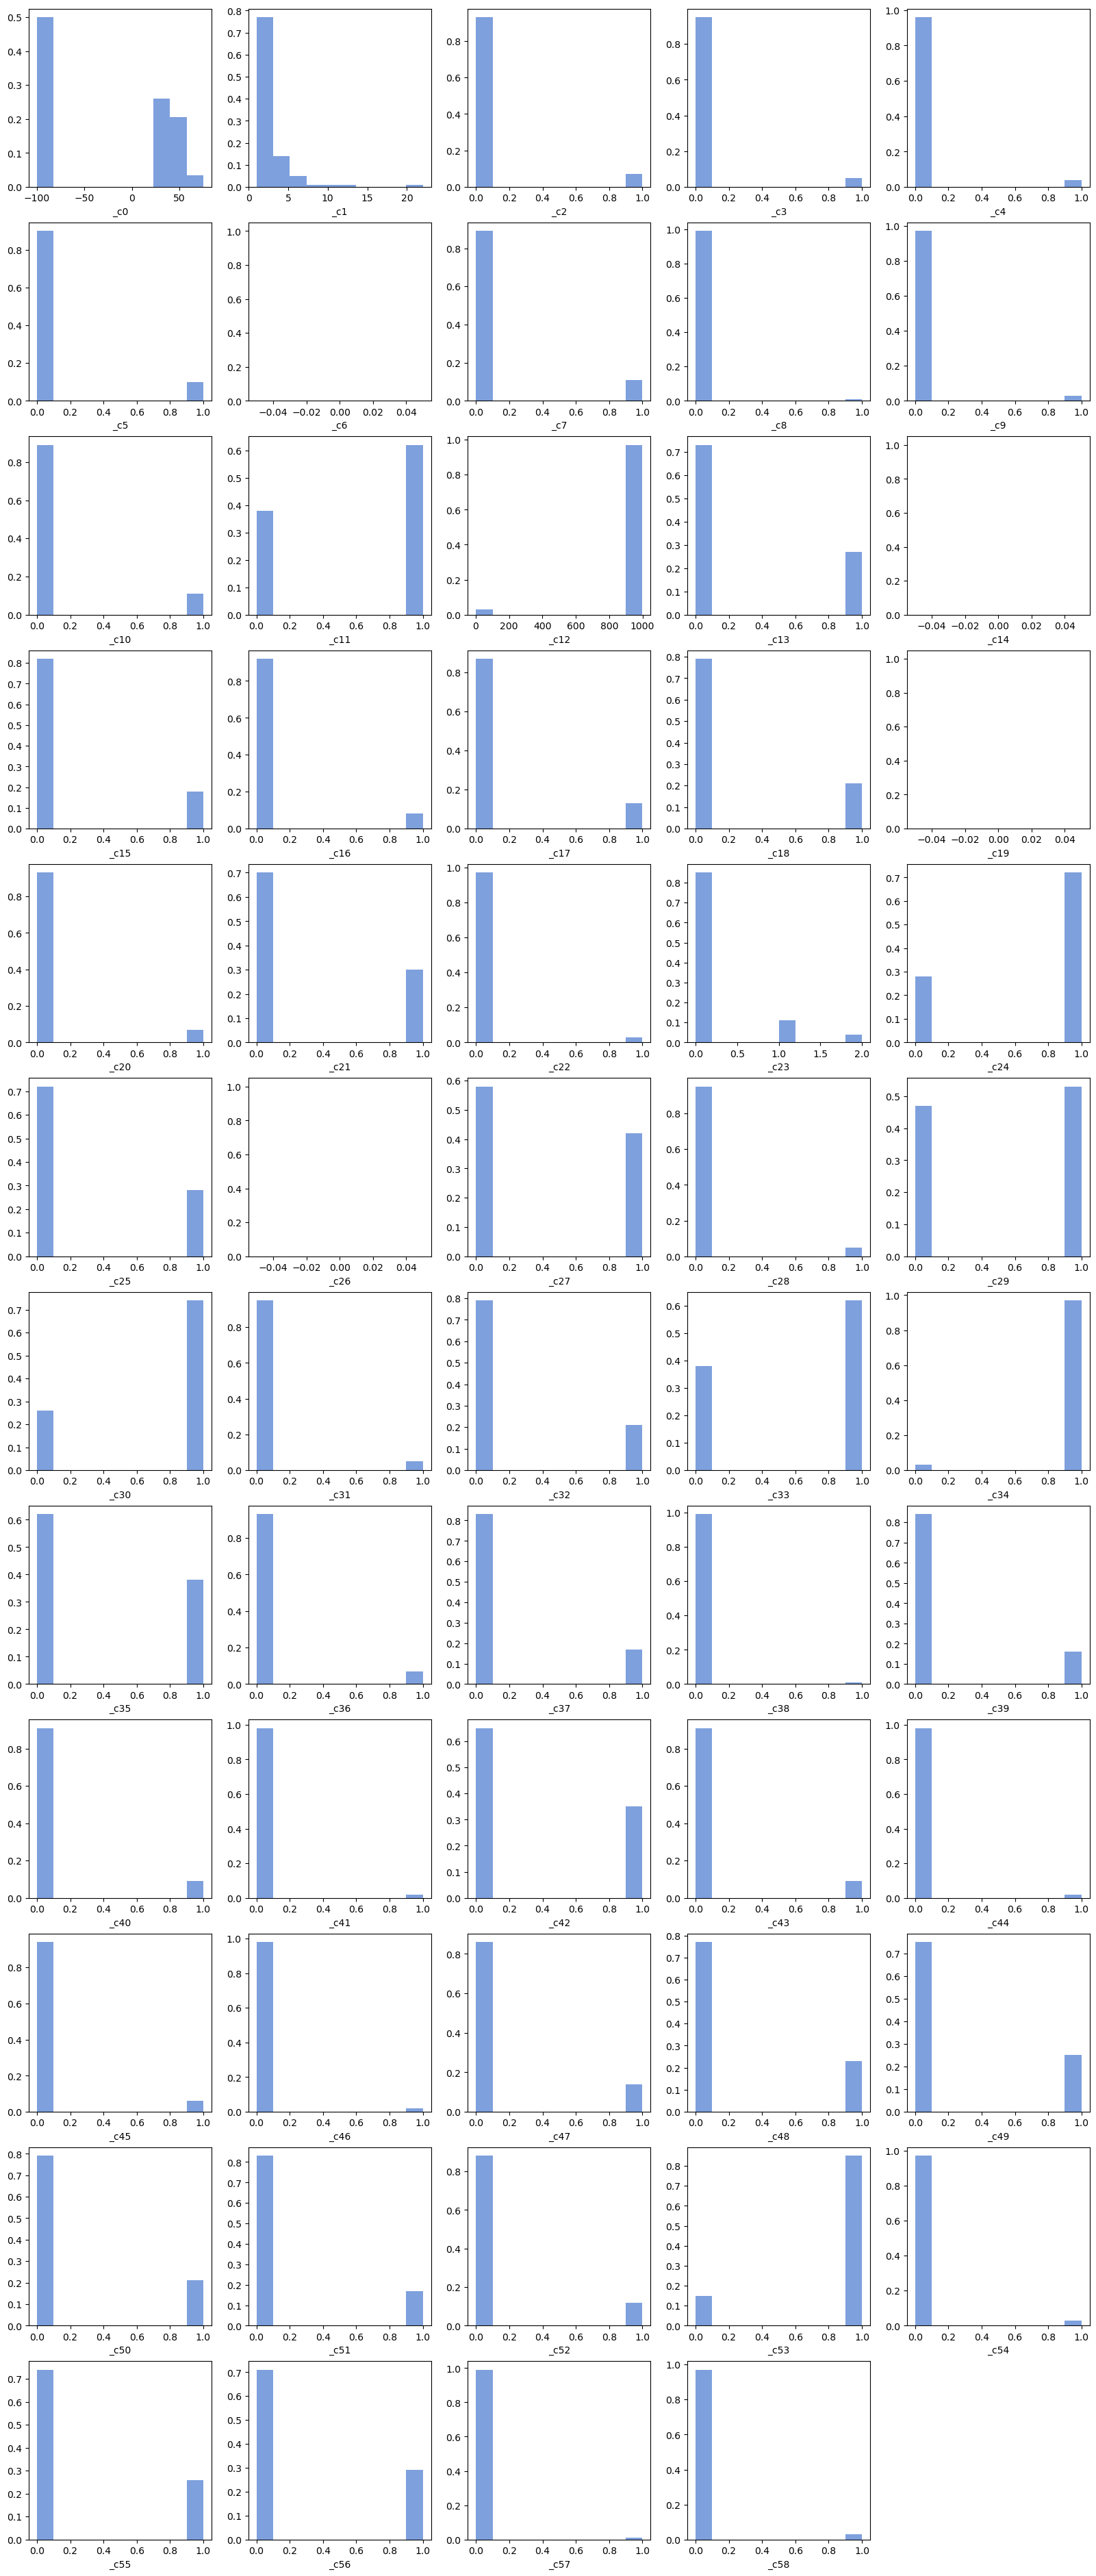

In [205]:
# show statistics on the captured features
mu.show_distributions(features)

,num_present,num_missing,mean,sum,std_dev,min,max
_c0,200,0,-29.37,-5874.0,70.963710,-99.99,75.0
_c1,200,0,2.67,534.0,2.895013,1.00,22.0
_c2,200,0,0.07,14.0,0.255147,0.00,1.0
_c3,200,0,0.05,10.0,0.217945,0.00,1.0
_c4,200,0,0.04,8.0,0.195959,0.00,1.0
_c5,200,0,0.10,20.0,0.300000,0.00,1.0
_c6,200,0,0.00,0.0,0.000000,0.00,0.0
_c7,200,0,0.11,22.0,0.312890,0.00,1.0
_c8,200,0,0.01,2.0,0.099499,0.00,1.0
_c9,200,0,0.03,6.0,0.170587,0.00,1.0


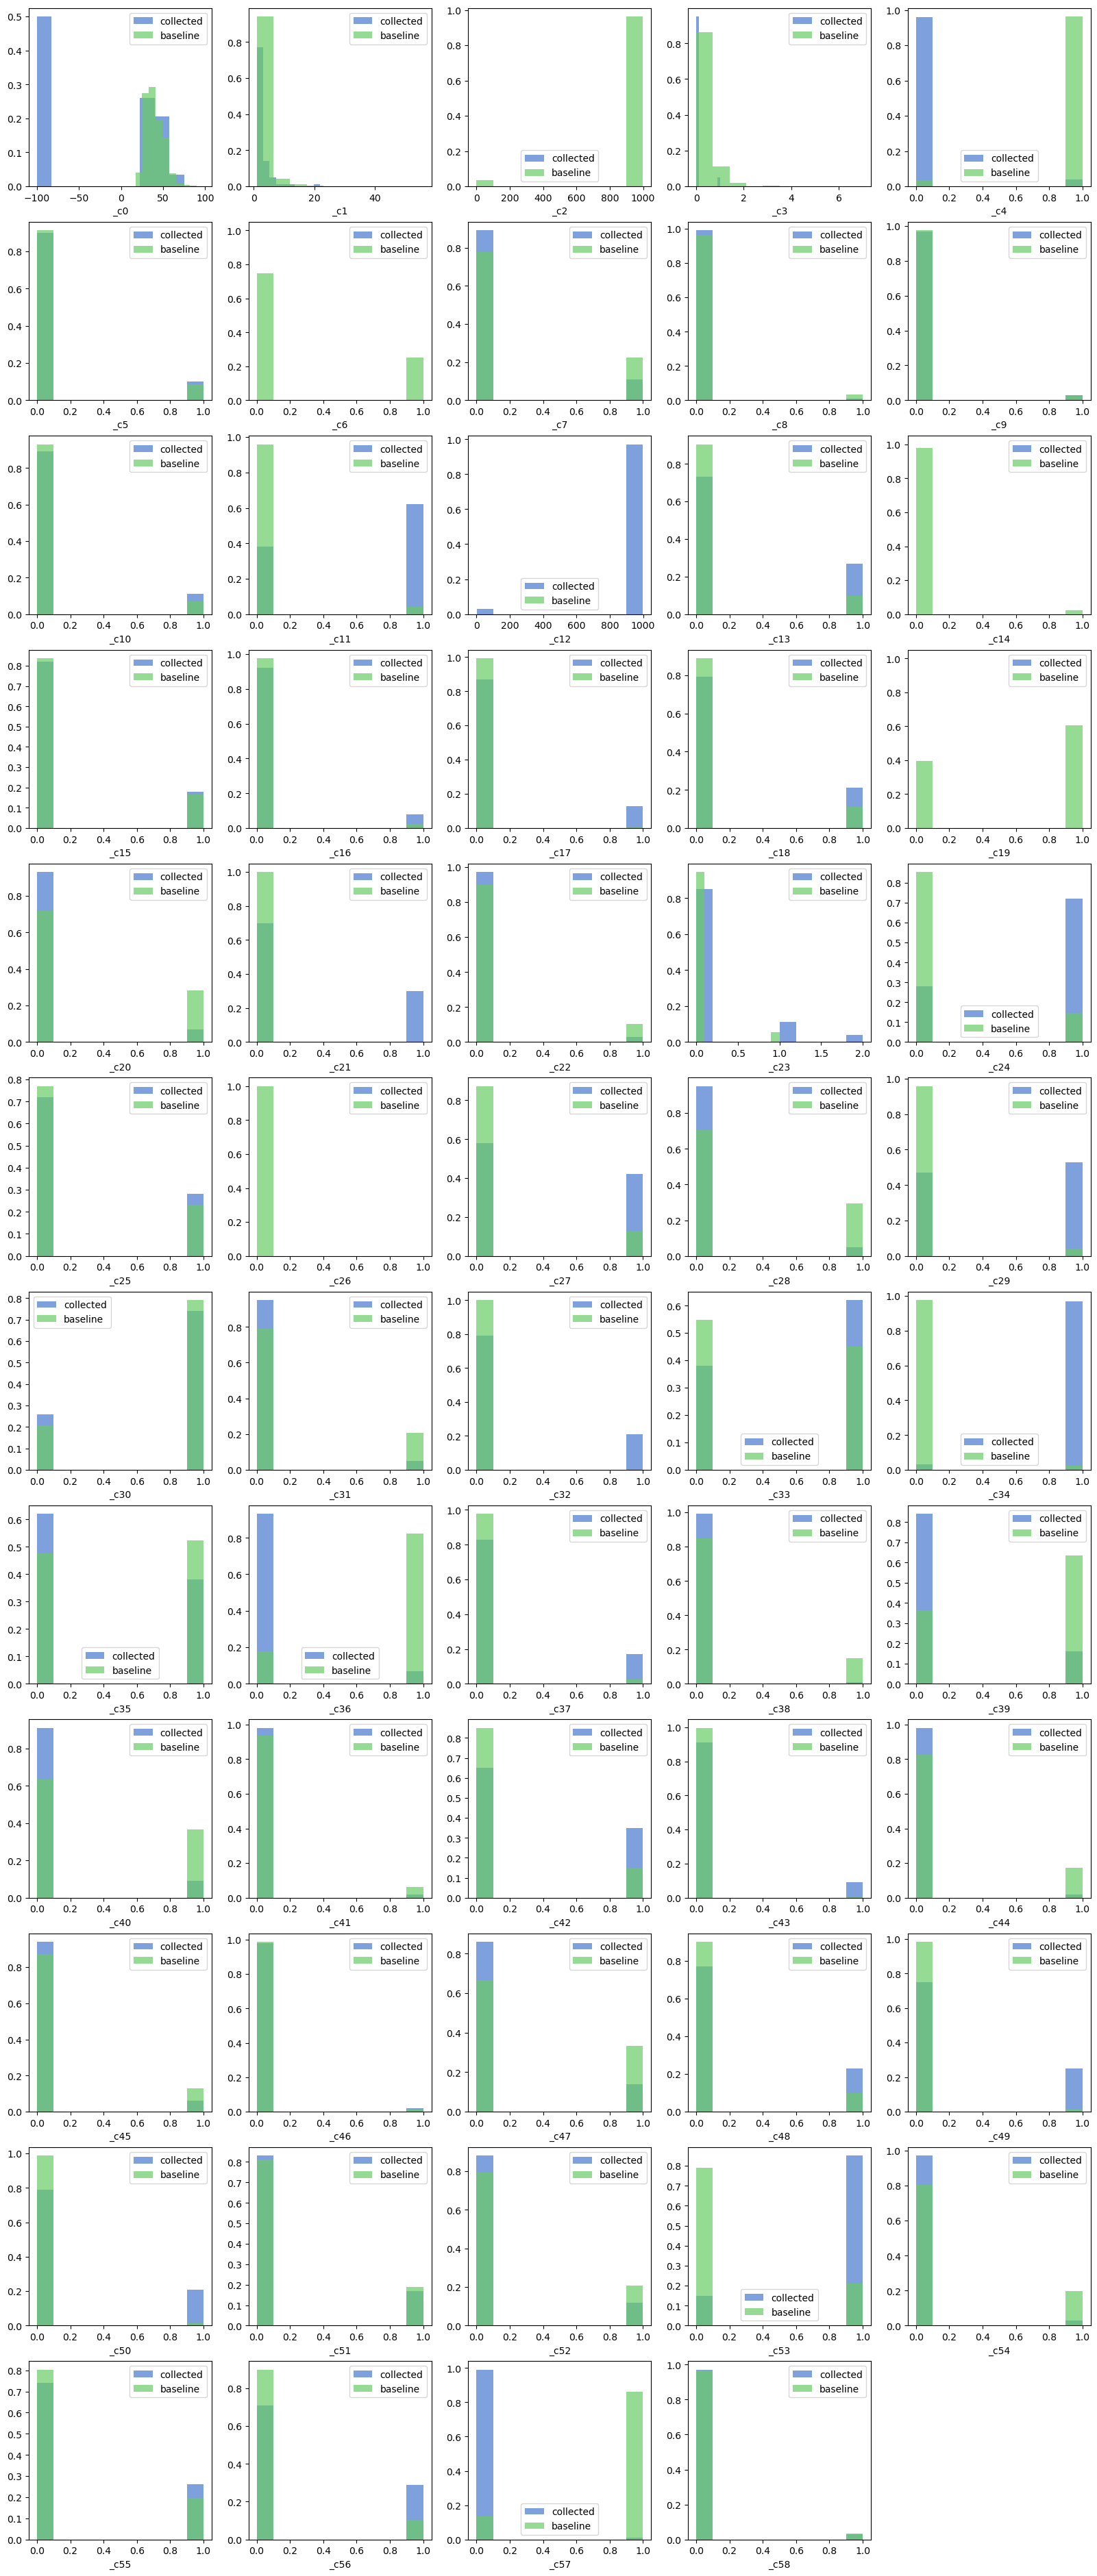

In [206]:
# show distribution comparison between captured features and baseline features
mu.show_distributions(features, feature_baselines)

---

## Part 2: Monitor model quality
Model quality monitoring jobs monitor the performance of a model by comparing the predictions that the model makes with the actual ground truth labels that the model attempts to predict. To do this, model quality monitoring merges data that is captured from real-time inference with actual labels (ground truth labels) that you store in an Amazon S3 bucket, and then compares the predictions with the ground truth labels.

Model quality monitoring follows the same steps as data quality monitoring, but adds an additional step of merging the ground truth labels from Amazon S3 with the predictions captured from the real-time inference endpoint.

To monitor model quality, follow these steps:
1. Enable [data capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html)
1. [Create a baseline](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-baseline.html). A baseline job compares predictions from the model with ground truth labels in a baseline dataset
1. [Schedule monitoring jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-schedule.html)
1. [Ingest ground truth labels](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-merge.html) that model monitor merges with captured prediction data from real-time inference endpoint
1. [Intepret the results](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-results.html)
1. [Integrate model quality monitoring](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-cw.html) with Amazon CloudWatch and Amazon EventBridge

![](img/model-monitoring-architecture.png)

In the following sections you implement the model quality monitoring in this lab environment.

### Define helper functions
Some helper functions for model quality monitoring setup.

In [207]:
def generate_ground_truth_with_id(inference_id):
    # set random seed to get consistent results
    random.seed(inference_id) 
    rand = random.random()
    
    # format required by the merge container.
    return {
        "groundTruthData": {
            "data": "0" if rand < 0.5 else "1", #str(rand),
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id), # eventId must correlate with the eventId in the data capture file
        },
        "eventVersion": "0",
    }

In [208]:
def upload_ground_truth(ground_truth_upload_s3_url, file_name, records, upload_time):
    target_s3_uri = f"{ground_truth_upload_s3_url}/{upload_time:%Y/%m/%d/%H}/{file_name}"
    number_of_records = len(records.split('\n'))
    print(f"Uploading {number_of_records} records to {target_s3_uri}")
    
    S3Uploader.upload_string_as_file_body(records, target_s3_uri)
    
    return target_s3_uri

### Create a model quality monitor
Use the Python SDK class [`ModelQualityMonitor`](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelQualityMonitor) to create a model quality monitor and interact with it:

In [209]:
model_monitor = ModelQualityMonitor(
    role=sm_role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Run a model quality baseline job
Your model building pipeline in the [step 3](03-sagemaker-pipeline.ipynb) notebook saved the model predictions on the test dataset. Now you use the model monitor to establish a [model performance baseline](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-baseline.html). The baseline dataset contains three columns with `predictions`, `probability`, and `label` values.

In [210]:
!aws s3 ls {prediction_baseline_s3_url}/

2024-02-17 16:37:17      63064 prediction_baseline.csv


In [211]:
prediction_baseline_results_s3_url = f"{prediction_baseline_s3_url}/results"
model_mon_reports_s3_url = f"{prediction_baseline_s3_url}/reports"
prediction_baseline_dataset_uri = f"{prediction_baseline_s3_url}/prediction_baseline.csv"

In [212]:
model_baseline_job_name = f"from-idea-to-prod-model-baselining-{strftime('%d-%H-%M-%S', gmtime())}-{str(uuid.uuid4())[:8]}"

model_baseline_job = model_monitor.suggest_baseline(
    baseline_dataset=prediction_baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri = prediction_baseline_results_s3_url, 
    problem_type="BinaryClassification",
    inference_attribute= "prediction", # The column in the dataset that contains predictions
    probability_attribute= "probability", # The column in the dataset that contains probabilities
    ground_truth_attribute= "label", # The column in the dataset that contains ground truth labels
    job_name=model_baseline_job_name,
)

print(model_baseline_job_name)

INFO:sagemaker:Creating processing-job with name from-idea-to-prod-model-baselining-19-10-54-23-b40bfd2d


from-idea-to-prod-model-baselining-19-10-54-23-b40bfd2d


In [216]:
model_baseline_job.wait(logs=False)

....................................!

### Inspect the generated baseline statistics and constraints


In [217]:
!aws s3 ls {prediction_baseline_results_s3_url}/

2024-02-19 11:00:24       1372 constraints.json
2024-02-19 11:00:24      86680 statistics.json


In [218]:
latest_model_baseline_job = model_monitor.latest_baselining_job
pd.DataFrame(latest_model_baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.196687,LessThanThreshold
precision,0.693431,LessThanThreshold
accuracy,0.895606,LessThanThreshold
true_positive_rate,0.196687,LessThanThreshold
true_negative_rate,0.988449,LessThanThreshold
false_positive_rate,0.011551,GreaterThanThreshold
false_negative_rate,0.803313,GreaterThanThreshold
auc,0.770121,LessThanThreshold
f0_5,0.460718,LessThanThreshold
f1,0.306452,LessThanThreshold


In [219]:
pd.DataFrame(latest_model_baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]["confusion_matrix"])

,0,1
0,3594,388
1,42,95


In [220]:
pd.json_normalize(latest_model_baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]).T

,0
confusion_matrix.0.0,3594
confusion_matrix.0.1,42
confusion_matrix.1.0,388
confusion_matrix.1.1,95
recall.value,0.196687
recall.standard_deviation,0.004933
precision.value,0.693431
precision.standard_deviation,0.005398
accuracy.value,0.895606
accuracy.standard_deviation,0.001722


### Generate endpoint traffic
Generate synthetic traffic to the endpoint to capture inference input and output.

In [221]:
# Remove previous data capture saved to the S3 bucket
latest_data_capture_s3_url = get_latest_data_capture_s3_url(data_capture_bucket, data_capture_prefix)

Found 4 files in s3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/data-capture
Latest data capture S3 url: s3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/data-capture/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/18/22


In [223]:
# If you run this notebook not the first time, there might be some data capture files from the previous runs
# We recommend to delete all existing files under the data capture S3 path to avoid any inconsistences
# Uncomment and run the following line to delete all files under the data capture S3 path

# !aws s3 rm {latest_data_capture_s3_url} --recursive

In [224]:
test_x.shape

(100, 59)

In [225]:
generate_endpoint_traffic(predictor, test_x)

100%|██████████| 100/100 [00:01<00:00, 77.13it/s]


Wait until captured data appears in the Amazon S3 bucket, it may take several minutes. The capture data is delivered to the Amazon S3 prefix `{data-capture-prefix}/{EndpointName}/{VariantName}/{year}/{month}/{day}/{UTC hour}`.

In [228]:
!aws s3 ls {data_capture_s3_url} --recursive

2024-02-17 15:20:25     589173 from-idea-to-prod/xgboost/data-capture/from-idea-to-prod-endpoint-17-15-12-53/AllTraffic/2024/02/17/15/19-22-501-00423608-0ea8-4f8a-8f31-90628cb9198e.jsonl
2024-02-18 21:34:57      48695 from-idea-to-prod/xgboost/data-capture/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/18/21/33-52-678-4f67e7bf-339e-48a0-8969-a995a7298a70.jsonl
2024-02-19 11:03:17      48695 from-idea-to-prod/xgboost/data-capture/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11/02-14-592-e36db9a7-8818-4ffa-82fc-85de958aa38e.jsonl


### Ingest ground truth data
<div class="alert alert-info"> 💡 <strong> Run this section only after the capture data from the latest endpoint invocations has appeared in the Amazon S3 bucket. The capture data is organized based on the UTC hour in which the invocation happened.</strong>
</div>

For model monitoring you must have ground truths labels that the model monitor merges with captured inference data from the endpoint.

In this lab environment you generate synthetic ground truth data to use with the model quality monitoring. In a real-time project you need to implement a workflow to produce and store the ground truth labels to evaluate the quality of the model predictions.

The following code cells generate and save synthetic ground truth labels for all inference records in the latest capture data files.

In [229]:
# Set the S3 url where to store the ground truth labels
variant_name = sm.describe_endpoint(EndpointName=predictor.endpoint_name)["ProductionVariants"][0]["VariantName"]
ground_truth_upload_s3_url = f"s3://{data_capture_bucket}/ground_truth_data/{predictor.endpoint_name}/{variant_name}"
ground_truth_upload_s3_url

's3://sagemaker-us-east-1-165419204787/ground_truth_data/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic'

In [230]:
# Get the S3 prefix where the latest capture data has been delivered
latest_data_capture_s3_url = get_latest_data_capture_s3_url(data_capture_bucket, data_capture_prefix)
latest_data_capture_prefix = '/'.join(latest_data_capture_s3_url.split('/')[3:])

Found 3 files in s3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/data-capture
Latest data capture S3 url: s3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/data-capture/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11


In [231]:
# Get the list of capture data file prefixes in the latest capture data location
capture_files = get_file_list(data_capture_bucket, latest_data_capture_prefix)

assert capture_files, f"No capture data files found in {latest_data_capture_prefix}. Generate endpoint traffic and wait until capture data appears in the bucket!"

# For each capture data file get the eventIds and generate correlated ground truth labels
for f in capture_files:
    f_name = f.split('/')[-1]
    
    print(f"Downloading {f}")
    S3Downloader.download(f"s3://{data_capture_bucket}/{f}", "./tmp")
    
    print(f"Reading inference ids from the file: ./tmp/{f_name}")
    with jsonlines.open(f"./tmp/{f_name}") as reader: 
        ground_truth_records = "\n".join([
            json.dumps(r) for r in [generate_ground_truth_with_id(l["eventMetadata"]["eventId"]) for l in reader]
        ])
    lastest_ground_truth_s3_uri = upload_ground_truth(ground_truth_upload_s3_url, f"gt-{f_name}", ground_truth_records, datetime.utcnow())

Found 1 files in s3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/data-capture/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11
Reading inference ids from the file: ./tmp/02-14-592-e36db9a7-8818-4ffa-82fc-85de958aa38e.jsonl
Uploading 100 records to s3://sagemaker-us-east-1-165419204787/ground_truth_data/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11/gt-02-14-592-e36db9a7-8818-4ffa-82fc-85de958aa38e.jsonl


In [232]:
# List uploaded ground truth files
!aws s3 ls {ground_truth_upload_s3_url} --recursive

2024-02-19 11:04:10      14499 ground_truth_data/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11/gt-02-14-592-e36db9a7-8818-4ffa-82fc-85de958aa38e.jsonl


Download the last ingested ground truth data file and see it's content:

In [233]:
# Download the last ground truth file to Studio's EFS
!aws s3 cp {lastest_ground_truth_s3_uri} ./tmp/groundtruth.jsonl

download: s3://sagemaker-us-east-1-165419204787/ground_truth_data/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11/gt-02-14-592-e36db9a7-8818-4ffa-82fc-85de958aa38e.jsonl to tmp/groundtruth.jsonl


In [234]:
!head ./tmp/groundtruth.jsonl

{"groundTruthData": {"data": "1", "encoding": "CSV"}, "eventMetadata": {"eventId": "8d1b85f8-c19d-42d8-87d7-1158b5e3a333"}, "eventVersion": "0"}
{"groundTruthData": {"data": "1", "encoding": "CSV"}, "eventMetadata": {"eventId": "c9055850-450e-40b9-9094-38696cd0cc86"}, "eventVersion": "0"}
{"groundTruthData": {"data": "1", "encoding": "CSV"}, "eventMetadata": {"eventId": "f01f35c8-b512-4f77-9763-2c6f7810aade"}, "eventVersion": "0"}
{"groundTruthData": {"data": "0", "encoding": "CSV"}, "eventMetadata": {"eventId": "63564f1d-5e08-4a55-b664-2ef6e7ac29bd"}, "eventVersion": "0"}
{"groundTruthData": {"data": "1", "encoding": "CSV"}, "eventMetadata": {"eventId": "6d3ad022-4d28-453d-b86b-11bfc1f1ba0e"}, "eventVersion": "0"}
{"groundTruthData": {"data": "1", "encoding": "CSV"}, "eventMetadata": {"eventId": "44e7855e-f822-411c-a73d-1ac935914c60"}, "eventVersion": "0"}
{"groundTruthData": {"data": "1", "encoding": "CSV"}, "eventMetadata": {"eventId": "7315ccba-912e-489a-9dd6-68235871a74a"}, "event

### Create a model monitoring schedule
Now after you have the capture data and the ground truth data, you can create a model monitoring schedule.
Use [`create_monitoring_schedule()`](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelQualityMonitor.create_monitoring_schedule) method of the `ModelQualityMonitor` class to create a model quality monitoring schedule.

In [235]:
endpoint_input = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    probability_attribute="0",
    probability_threshold_attribute=0.5,
    destination="/opt/ml/processing/input_data",
)

In [236]:
model_mon_schedule_name = "from-idea-to-prod-model-monitor-schedule-" + strftime(
    "%Y-%m-%d-%H-%M-%S", gmtime()
)

model_monitor.create_monitoring_schedule(
    monitor_schedule_name=model_mon_schedule_name,
    endpoint_input=endpoint_input,
    problem_type="BinaryClassification",
    # record_preprocessor_script=f"{record_preprocessor_s3_url}/record_preprocessor.py",
    # post_analytics_processor_script=s3_code_postprocessor_uri,
    output_s3_uri=model_mon_reports_s3_url,
    ground_truth_input=ground_truth_upload_s3_url,
    constraints=model_monitor.suggested_constraints() if model_monitor.latest_baselining_job else f"{prediction_baseline_results_s3_url}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14


In [237]:
while model_monitor.describe_schedule()['MonitoringScheduleStatus'] != "Scheduled":
    print(f"Waiting until model monitoring status becomes Scheduled")
    time.sleep(3)
    
model_monitor.describe_schedule()

Waiting until model monitoring status becomes Scheduled
Waiting until model monitoring status becomes Scheduled


{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:165419204787:monitoring-schedule/from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14',
 'MonitoringScheduleName': 'from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14',
 'MonitoringScheduleStatus': 'Scheduled',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2024, 2, 19, 11, 5, 14, 947000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 2, 19, 11, 5, 21, 678000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2024-02-19-11-05-14-509',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'from-idea-to-prod-endpoint-18-21-11-19',
 'ResponseMetadata': {'RequestId': '582ccbb5-9123-4327-a2b0-14e71f9a1c37',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '582ccbb5-9123-4327-a2b0-14e71f9a1c37',
   'content-type': 'application/x-amz-json-1.1',


The endpoint has two scheduled monitors now, a data quality and a model quality monitor:

In [238]:
predictor.list_monitors()

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### See model monitoring schedule executions
<div class="alert alert-info"> 💡 You created a model monitoring schedule which runs every hour. <strong>You need to wait until you cross the hour boundary to see any executions.</strong>
</div>
 
A monitoring job started by the schedule looks for the ground truth data under the Amazon S3 prefix `{ground_truth_upload_s3_url}/{year}/{month}/{day}/{UTC hour}/`. If there is no ground truth label datasets under this prefix, the model monitoring job fails with an exception `No S3 objects found under S3 URL ...`. In the previous section **Ingest ground truth data** you created a synthetic ground truth dataset and saved it under the correct prefix.

Model quality monitor runs two processing jobs for each schedule execution:
1. A ground truth merge job to contatenate capture data and ground truth label datasets based on the `eventId`
2. A model quality monitoring job to evaluate model performance compared to the baseline

You can see these two jobs for each monitor execution in the SageMaker console under **Processing jobs**:
![](img/model-quality-monitor-execution.png)

#### Inspect the lastest model monitor execution

In [239]:
# call describe_schedule to see the status of the latest completed execution
model_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:165419204787:monitoring-schedule/from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14',
 'MonitoringScheduleName': 'from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14',
 'MonitoringScheduleStatus': 'Scheduled',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2024, 2, 19, 11, 5, 14, 947000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 2, 19, 16, 14, 19, 199000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2024-02-19-11-05-14-509',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'from-idea-to-prod-endpoint-18-21-11-19',
 'LastMonitoringExecutionSummary': {'MonitoringScheduleName': 'from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14',
  'ScheduledTime': datetime.datetime(2024, 2, 19, 16, 0, tzinfo=tzlocal()),
  'CreationTime': dateti

In [240]:
# List all _completed_ model monitor executions
model_mon_executions = model_monitor.list_executions()

In [241]:
model_mon_executions

In [242]:
# See the details of the latest model monitor execution
latest_model_mon_execution = get_latest_monitor_execution(model_monitor)
execution_details = latest_model_mon_execution.describe()
execution_details

!Latest execution status: Completed
Latest execution result: CompletedWithViolations: Job completed successfully with 10 violations.
Report Uri: s3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/prediction_baseline/reports/from-idea-to-prod-endpoint-18-21-11-19/from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14/2024/02/19/12


{'ProcessingInputs': [{'InputName': 'constraints',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/prediction_baseline/results/constraints.json',
    'LocalPath': '/opt/ml/processing/baseline/constraints',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/prediction_baseline/reports/merge/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11',
    'LocalPath': '/opt/ml/processing/input_data/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output': {'S3Uri': 's3://sagemaker-us-east-1

#### See the execution reports
Each completed model monitor execution produces new statistics, constraints, and violations reports for the capture data. You have various ways to access these reports:
- directly access the files on Amazon S3 under the job output S3 uri
- use the Python SDK class [`MonitoringExecution`](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.MonitoringExecution)
- use [`latest_monitoring_statistics`](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelMonitor.latest_monitoring_statistics) and [`latest_monitoring_constraint_violations`](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelMonitor.latest_monitoring_constraint_violations) methods of the [`ModelMonitor`](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelMonitor) class

In [243]:
# Get the job output S3 uri
mon_job_output_s3_uri = execution_details["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
mon_job_output_s3_uri

's3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/prediction_baseline/reports/from-idea-to-prod-endpoint-18-21-11-19/from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14/2024/02/19/12'

In [244]:
# Same S3 uri is accessible via the MonitoringExecution class
latest_model_mon_execution.output.destination

's3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/prediction_baseline/reports/from-idea-to-prod-endpoint-18-21-11-19/from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14/2024/02/19/12'

In [245]:
# See the generated files - new statistics, constraints, and violations
!aws s3 ls {mon_job_output_s3_uri} --recursive

2024-02-19 12:25:36       1997 from-idea-to-prod/xgboost/prediction_baseline/reports/from-idea-to-prod-endpoint-18-21-11-19/from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14/2024/02/19/12/constraint_violations.json
2024-02-19 12:25:36       1346 from-idea-to-prod/xgboost/prediction_baseline/reports/from-idea-to-prod-endpoint-18-21-11-19/from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14/2024/02/19/12/constraints.json
2024-02-19 12:25:36       9508 from-idea-to-prod/xgboost/prediction_baseline/reports/from-idea-to-prod-endpoint-18-21-11-19/from-idea-to-prod-model-monitor-schedule-2024-02-19-11-05-14/2024/02/19/12/statistics.json


<div class="alert alert-info"> 💡 Since you generated random synthetic ground truth labels, you expect to see some violations, more specifically, `LessThanThreshold` constraint violation for various model performance metrics, such as `auc`, `accuracy`, and `precision`.
</div>

In [246]:
# Get the violation report from the MonitoringExecution class
last_execution_violations = latest_model_mon_execution.constraint_violations()

In [247]:
pd.json_normalize(last_execution_violations.body_dict["violations"]).head()

,constraint_check_type,description,metric_name
0,LessThanThreshold,Metric auc with 0.510404161664666 was LessThanThreshold '0.7701214220800956',auc
1,LessThanThreshold,Metric precision with 0.5 was LessThanThreshold '0.6934306569343066',precision
2,LessThanThreshold,Metric truePositiveRate with 0.02040816326530612 was LessThanThreshold '0.19668737060041408',truePositiveRate
3,LessThanThreshold,Metric f1 with 0.039215686274509796 was LessThanThreshold '0.3064516129032258',f1
4,LessThanThreshold,Metric accuracy with 0.51 was LessThanThreshold '0.8956057295460063',accuracy


You can access the violation report directly from the model monitor class:

In [248]:
# Use the ModelMonitor class
violations = model_monitor.latest_monitoring_constraint_violations()
pd.json_normalize(violations.body_dict["violations"]).head()

,constraint_check_type,description,metric_name
0,LessThanThreshold,Metric auc with 0.510404161664666 was LessThanThreshold '0.7701214220800956',auc
1,LessThanThreshold,Metric precision with 0.5 was LessThanThreshold '0.6934306569343066',precision
2,LessThanThreshold,Metric truePositiveRate with 0.02040816326530612 was LessThanThreshold '0.19668737060041408',truePositiveRate
3,LessThanThreshold,Metric f1 with 0.039215686274509796 was LessThanThreshold '0.3064516129032258',f1
4,LessThanThreshold,Metric accuracy with 0.51 was LessThanThreshold '0.8956057295460063',accuracy


#### See the merged datasets
Finally let's take a look on the merged datasets generated by the merge job. The merged dataset contains inference input, inference output, and the ingested ground truth labels. The inference output and the ground truth are connected via `eventMetadata.eventId` identifier.

In [249]:
# Get the S3 url to the merge datasets from the monitor job inputs
mon_job_merge_input_s3_uri = execution_details["ProcessingInputs"][1]["S3Input"]["S3Uri"]

mon_job_merge_bucket = mon_job_merge_input_s3_uri.split('/')[2]
mon_job_merge_prefix = '/'.join(mon_job_merge_input_s3_uri.split('/')[3:])

In [250]:
merge_files = get_file_list(mon_job_merge_bucket, mon_job_merge_prefix)

if merge_files:
    S3Downloader.download(f"s3://{mon_job_merge_bucket}/{merge_files[0]}", f"./tmp")

    print(f"Content of the merge file:")
    # Read the jsonl file and show two first objects
    with jsonlines.open(f"./tmp/{merge_files[0].split('/')[-1]}") as reader:      
        print(json.dumps(reader.read(), indent=2))
        print(json.dumps(reader.read(), indent=2))

Found 1 files in s3://sagemaker-us-east-1-165419204787/from-idea-to-prod/xgboost/prediction_baseline/reports/merge/from-idea-to-prod-endpoint-18-21-11-19/AllTraffic/2024/02/19/11
sagemaker.config INFO - Fetched defaults config from location: /root/.config/sagemaker/config.yaml
Content of the merge file:
{
  "eventVersion": "0",
  "groundTruthData": {
    "data": "1",
    "encoding": "CSV"
  },
  "captureData": {
    "endpointInput": {
      "data": "31,5,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0",
      "encoding": "CSV",
      "mode": "INPUT",
      "observedContentType": "text/csv"
    },
    "endpointOutput": {
      "data": "0.08869586139917374\n",
      "encoding": "CSV",
      "mode": "OUTPUT",
      "observedContentType": "text/csv; charset=utf-8"
    }
  },
  "eventMetadata": {
    "eventId": "8d1b85f8-c19d-42d8-87d7-1158b5e3a333",
    "inferenceTime": "2024-02-19T11:02:14Z"
  }
}
{
  "eventVersion": "0",

## Additional monitoring
Additionally to data and model quality monitoring with Model Monitor, you can use Amazon SageMaker Clarify to:
- [Monitor bias drift](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-model-monitor-bias-drift.html)
- [Monitor feature attribution drift](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-model-monitor-feature-attribution-drift.html)

Refer to a sample notebook [Monitoring bias drift and feature attribution drift Amazon SageMaker Clarify](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/fairness_and_explainability/SageMaker-Model-Monitor-Fairness-and-Explainability.html) for a hands-on example and more details.

## Use SageMaker Studio for data and model monitoring
You can use Studio UX to enable and configure data and model monitoring and to visualize results. You can view the details of any monitoring job run, and you can create charts that show the baseline and captured values for any metric that the monitoring job calculates.

Navigate to **Home** to the left side bar and choose **Deployments** and then **Endpoints** in the list. Click on an endpoint for which you would like to configure the model monitoring:

![](img/endpoints.png)

In the displayed **Endpoint details** pane you can configure data and model monitoring:

![](img/model-monitoring-ux.png)

## Clean-up resources
Stop and remove monitoring schedule for the endpont.

In [ ]:
for monitor in predictor.list_monitors():
    try:
        monitor.stop_monitoring_schedule()
        monitor.delete_monitoring_schedule()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f"ValidationException: {e.response['Error']['Message']}. Wait until the monitoring job is done and run the cell again.")
        else:
            raise e

### Final clean-up
This is the last notebook in this workshop. If you are finished with exploration, to avoid charges on your AWS account, run the [clean-up notebook](99-clean-up.ipynb).

<div class="alert alert-info">
You have at least one real-time endpoint active in your AWS account. To avoid charges, you must delete the endpoint. Go to the clean-up notebook.
</div>

## Further development ideas for your real-world projects
- Add [visualizations](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.html) for model monitoring reports
- Add data baselining, explainability report generation, and bias report to the model building pipeline
- Implement [model quality monitoring](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality.html)
- Try different inference options such as [serverless](https://docs.aws.amazon.com/sagemaker/latest/dg/serverless-endpoints.html) or [asynchronous](https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference.html) inference
- Address security considerations for your ML environment and solutions. Start with the developer guide [Security in Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/security.html)
- Implement [deployment guardrails](https://docs.aws.amazon.com/sagemaker/latest/dg/deployment-guardrails.html) to control how to update your models in production

## Additional resources
- [AmazonSageMaker Model Monitor: A System for Real-Time Insights into Deployed Machine Learning Models](https://assets.amazon.science/97/cc/8dc8526547859351f46d2710aba9/amazon-sagemaker-model-monitor-a-system-for-real-time-insights-into-deployed-machine-learning-models.pdf)
- [Monitor models for data and model quality, bias, and explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html)
- [Monitor data quality](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-quality.html)
- [Model Monitor visualizations](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.html)
- [Monitor Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-overview.html)
- [Monitoring a Model in Production](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-model-monitor.html)
- [ModelMonitor for batch transform jobs](https://aws.amazon.com/about-aws/whats-new/2022/10/amazon-sagemaker-model-monitor-batch-transform-jobs/)
- [Security in Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/security.html)
- [Deployment guardrails](https://docs.aws.amazon.com/sagemaker/latest/dg/deployment-guardrails.html)
- [Design a compelling record filtering method with Amazon SageMaker Model Monitor](https://aws.amazon.com/blogs/machine-learning/design-a-compelling-record-filtering-method-with-amazon-sagemaker-model-monitor/)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>